In [72]:
import glob
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

# Old .objs -> check number of v, vn, vt, f

In [11]:
vt_path = './16b_data/input/obj/A03067.obj'
vts = []
fs = []
vns = []
vs = []

with open(vt_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        l = line.split(' ')
        if l[0] == 'vt':
            u = l[1]
            v = l[2].split('\n')[0]
            vts.append([u, v])
        elif l[0] == 'vn':
            vns.append([0, 0, 0])
        elif l[0] == 'v':
            vs.append([0, 0, 0])
        elif l[0] == 'f':
            fs_curr = []
            fl = [l[2], l[3], l[4]]
            for i in range(3):
                fi = '{}/{}/{}'.format(fl[0], fl[1], fl[2].split('\n')[0])
            fs.append(fs_curr)
    f.close()
print(len(vns))
print(len(vs))
print(len(vts))
print(len(fs))

0
1487
0
2970


ValueError: max() arg is an empty sequence

# Load f from other .obj

In [84]:
vt_path = r'./1_obj/modified_SMPL/SMPLWithSocks_tri.obj'
vts = []
fs = []
vns = []
vs = []

fi_maxes = [0, 0, 0]

with open(vt_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        l = line.split(' ')
        if l[0] == 'vt':
            u = l[1]
            v = l[2].split('\n')[0]
            vts.append([u, v])
        elif l[0] == 'vn':
            vns.append([0, 0, 0])
        elif l[0] == 'v':
            vs.append([0, 0, 0])
        elif l[0] == 'f':
            fs_curr = []
            for i in range(len(l) - 1):
                fi = l[i+1].split('/')
                fi[2] = fi[2].split('\n')[0]
                fl = '{}/{}/{}'.format(fi[0], fi[1], fi[2])
                for j in range(3):
                    fi_maxes[j] = max(fi_maxes[j], int(fi[j]))
                fs_curr.append(fl)
            fs.append(fs_curr)
    f.close()
print('v:',len(vs))
print('vn:', len(vns))
print('vt:', len(vts))
print(len(fs))
print(fi_maxes)

v: 6750
vn: 6750
vt: 7383
13496
[6750, 7383, 6750]


In [85]:
obj_dir = './9_data/input'
in_paths = glob.glob(obj_dir + '/*.obj')
for in_path in in_paths:
    obj_name = in_path.split('\\')[-1]
    out_path = in_path.split('\\')[0] + '/vt_added/' + obj_name

    # read current
    vs = []
    with open(in_path, 'r') as f:
        lines = f.readlines()
        
        for line in lines:
            l = line.split(' ')
            if l[0] == 'v':
                vs.append([l[1], l[2], l[3].split('\n')[0]])
            elif l[0] == 'vt' or l[0] == 'vn':
                assert(False)
        f.close()
    print('vs:', len(vs))
    
    # compute vn
    vns = np.zeros((len(vs), 3)).astype(float)
    for f in fs:
        v_indices = []
        for i in range(3):
            vi = int(f[i].split('/')[0])-1
            v_indices.append(vi)
        v0 = np.float32(vs[v_indices[0]])
        v1 = np.float32(vs[v_indices[1]])
        v2 = np.float32(vs[v_indices[2]])
        va = v0 - v1
        vb = v2 - v1
        normal = np.cross(vb, va)
        normal /= np.linalg.norm(normal)
        for i in range(3):
            vni = int(f[i].split('/')[2])-1
            vns[vni] += normal
        
    for vni in range(len(vns)):
        vns[vni] /= np.linalg.norm(vns[vni])
        
    # write new
    with open(out_path, 'w+') as f:
        for i, v in enumerate(vs):
            vn = vns[i]
            f.write('v {} {} {}\n'.format(v[0], v[1], v[2]))
            f.write('vn {} {} {}\n'.format(vn[0], vn[1], vn[2]))
        for vt in vts:
            f.write('vt {} {}\n'.format(vt[0], vt[1]))
        for face in fs:
            f.write('f')
            for fi in face:
                f.write(' {}'.format(fi))
            f.write('\n')
        f.close()
    print(out_path)
    print(len(vs))


vs: 6750
./9_data/input/vt_added/03052Interpo_mm.obj
6750
vs: 6750
./9_data/input/vt_added/03990Interpo_mm.obj
6750
vs: 6750
./9_data/input/vt_added/04917Interpo_mm.obj
6750
vs: 6750
./9_data/input/vt_added/06950Interpo_mm.obj
6750


### check

In [86]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


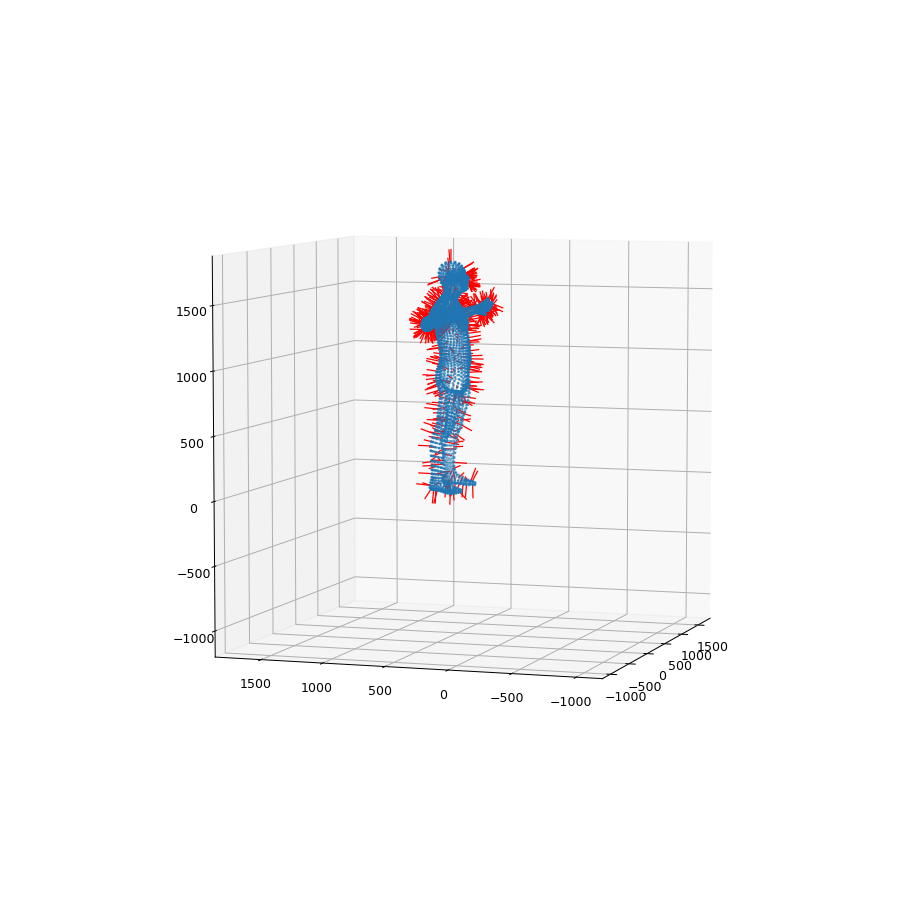

In [87]:
for in_path in in_paths:
    obj_name = in_path.split('\\')[-1]
    out_path = in_path.split('\\')[0] + '/vt_added/' + obj_name# read current
    vs = []
    fs = []
    vns = []
    with open(out_path, 'r') as f:
        lines = f.readlines()
        
        for line in lines:
            l = line.split(' ')
            if l[0] == 'v':
                vs.append([l[1], l[2], l[3].split('\n')[0]])
            elif l[0] == 'vn':
                vns.append([l[1], l[2], l[3].split('\n')[0]])
            elif l[0] == 'f':
                fs_curr = []
                for i in range(3):
                    fi = l[i+1].split('/')
                    fi[2] = fi[2].split('\n')[0]
                    fs_curr.append(fi)
                fs.append(fs_curr)    
        f.close()
    vs = np.float32(vs)
    vns = np.float32(vns)
    
    
    v1 = vs + 100*vns
    lim = (np.min(vs), np.max(vs))
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vs[:, 0], vs[:, 1], vs[:, 2], s=1)
    for i in range(len(vns)):
        if i % 10 == 0:
            ax.plot([vs[i,0], v1[i,0]], [vs[i,1], v1[i,1]], [vs[i,2], v1[i,2]], c='r', linewidth=1)
    ax.set_xlim([lim[0], lim[1]])
    ax.set_ylim([lim[0], lim[1]])
    ax.set_zlim([lim[0], lim[1]])
    
    plt.show()
    break
    